# Crime Data from New York State in 2013

For this exercise, we will examine [crime data in New York State](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls), made avaiable by the FBI. The goal of the exercise is to build a multivariable regression model to predict property crimes. 

We will ultimately specify the model as: 

Propertycrime=α+Population+Population2+Murder+Robbery

We'll start by setting up the notebook and reading in the data, trimming header and footer rows from the original data file.

In [156]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns
import scipy.stats as stats
sns.set_style("whitegrid")

import math

from IPython.display import display
from sklearn import linear_model
from sklearn import preprocessing
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from math import sqrt

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

#Read in the data, removing rows with metadata and footnotes.
crime = pd.read_excel('/Users/teresaoneill/Dropbox/Thinkful/Datasets/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', skiprows=4, skip_footer=3)
print(len(crime))
crime.head()

348


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


In [157]:
crime.columns=['city', 'population','violent_crime', 'murder', 'rape1', 'rape2', 'robbery','agg_assault','property_crime','burlary','larceny','vehicle','arson']
#Take the subset of relevant numeric columns.

#crime_sub = crime[['colums','columns2']]
crime_sub = crime[['population','murder','robbery','property_crime']]

First, let's take a look at the data, to identify and clean any anomalous values. Let's begin with any missing data, to look for patterns. Then we'll inspect the distribution of each of our relevant variables.

In [158]:
#Check for nulls.
for col in crime_sub.columns:
    print(crime_sub[pd.isnull(crime_sub[col])])

#Describe would also show how many datapoints are missing.

Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []
Empty DataFrame
Columns: [population, murder, robbery, property_crime]
Index: []


It appears that there are no missing values, so let's proceed to the summary statistics and some basic visualizations.

count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: population, dtype: float64
count   348.000
mean      1.566
std      18.304
min       0.000
25%       0.000
50%       0.000
75%       0.000
max     335.000
Name: murder, dtype: float64
count     348.000
mean       72.902
std      1031.033
min         0.000
25%         0.000
50%         1.000
75%         5.000
max     19170.000
Name: robbery, dtype: float64
count      348.000
mean       792.606
std       7659.725
min          0.000
25%         40.500
50%        112.500
75%        341.000
max     141971.000
Name: property_crime, dtype: float64


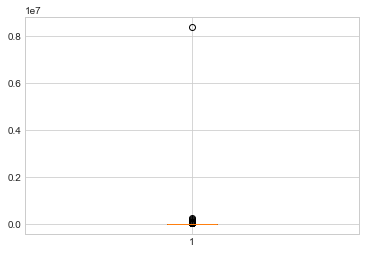

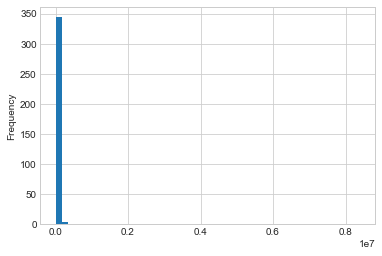

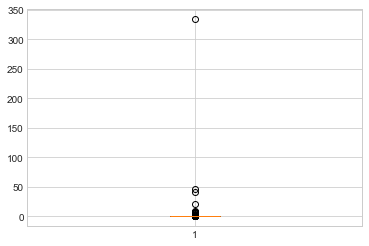

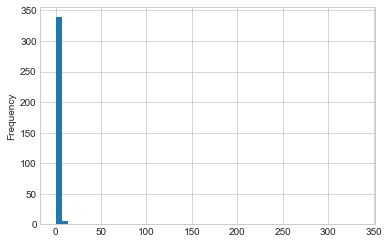

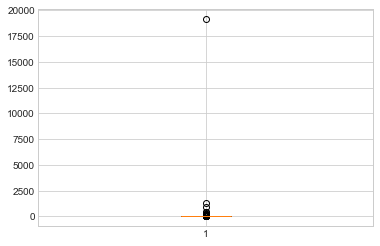

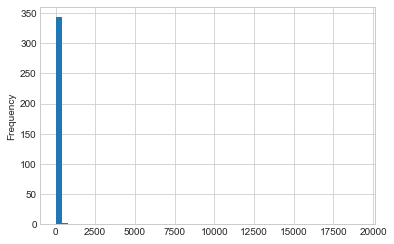

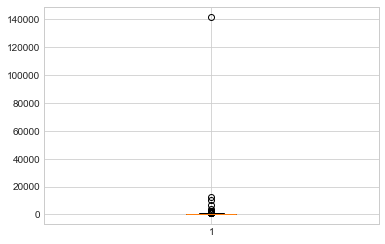

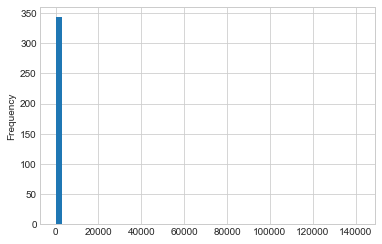

In [159]:
#Generate descriptions for each column.

for col in crime_sub.columns:
    print(crime_sub[col].describe())

#Look at the distributions of each with a boxplot and a histogram.

plt.boxplot(crime_sub['population'])
plt.show()

crime_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['murder'])
plt.show()
crime_sub['murder'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['robbery'])
plt.show()
crime_sub['robbery'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['property_crime'])
plt.show()
crime_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

These variables are not looking very normal! It appears that we have very densely clustered values at the low end of the range, with a few exteme outliers skewing everything. In fact, for the crime variables, there are quite a few zeros: at least 75% of cities have no murders and at least 25% of cities have no robberies. Ultimately, these two variables will be converted to binary categories, to better capture the distribution. For the sake of practice, however, and to prepare the population and property crimes variables for modeling, let's implement a strategy for dealing with outliers for the sake of practice.

Something we know about this dataset is that New York state includes New York City, the most populous city in the country by far, so we expect the extreme outlier values we find here. To deal with outliers (and any others), let's winsorize the data, assigning all values above the 95th percentile to the 95th percentile. We'll vizualize the variables again after winsorizing, paying particular attention to the dependent variable, property crimes. 

count     348.000
mean    13600.776
std     15249.263
min       526.000
25%      3003.000
50%      7233.500
75%     18427.500
max     57559.000
Name: population, dtype: float64
count   348.000
mean      0.193
std       0.510
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       2.000
Name: murder, dtype: float64
count   348.000
mean      6.917
std      14.534
min       0.000
25%       0.000
50%       1.000
75%       5.000
max      60.000
Name: robbery, dtype: float64
count    348.000
mean     280.201
std      376.580
min        0.000
25%       40.500
50%      112.500
75%      341.000
max     1391.000
Name: property_crime, dtype: float64


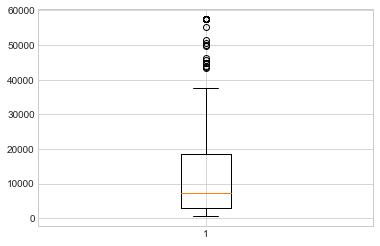

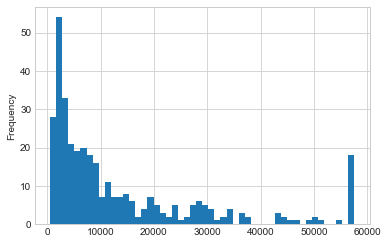

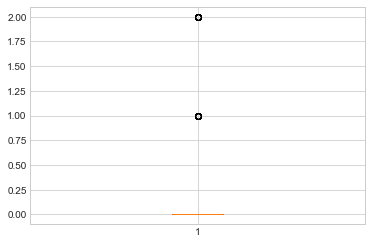

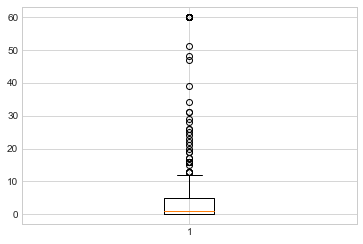

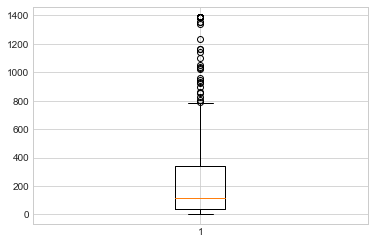

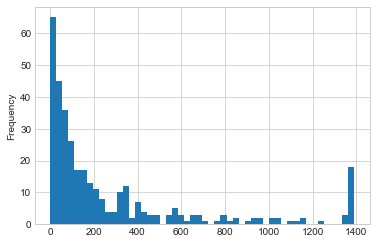

In [160]:
#Winsorize and take another look.
for col in crime_sub.columns:
    stats.mstats.winsorize(crime_sub[col], limits=(0, 0.05), inplace=True),
    print(crime_sub[col].describe())

plt.boxplot(crime_sub['population'])
plt.show()
crime_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime_sub['murder'])
plt.show()

plt.boxplot(crime_sub['robbery'])
plt.show()

plt.boxplot(crime_sub['property_crime'])
plt.show()

crime_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

The dependent variable will now be easier to work with, as it has more of a lognormal distribution, much like population. Let's take a quick look at the relationships between the variables before we recode robbery and murder as categorical. 

According to the plots and correlation matrix below, there is a strong linear relationship between population and property crimes, which is not surprizing. There is also a linear relationship between some of our input variables, which could lead to multicollinearity violation. Below, we'll do some recoding that will suit the model better.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


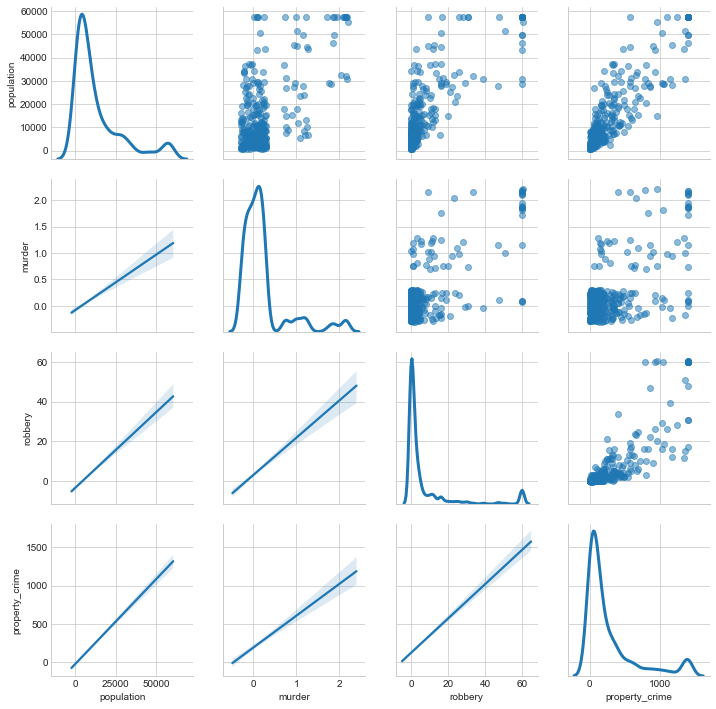

                population  murder  robbery  property_crime
population           1.000   0.625    0.801           0.896
murder               0.625   1.000    0.720           0.627
robbery              0.801   0.720    1.000           0.861
property_crime       0.896   0.627    0.861           1.000


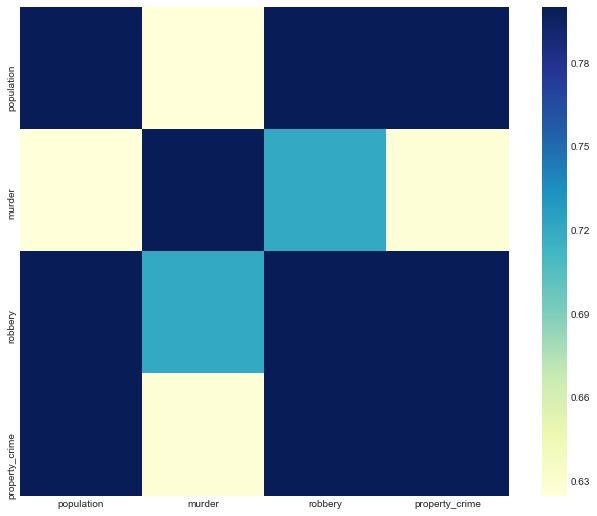

In [161]:
crime_jittered = crime_sub.loc[:, 'population':].dropna()

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(crime_jittered.shape)),
    columns=crime_jittered.columns
)

# Combine the data and the noise.

crime_jittered = crime_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(crime_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

# Take a look at the correlation matrix and visualize with a heatmap.

corrmat = crime_sub.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

For this model, robbery and murder will be recoded as binary categorical features. Let's recode them now, and take a look at the numer of observations in each level.

We'll also add a population squared variable to strengthen the predictive power of extreme population sizes, and a city variable to classify population centrs as urban areas of 200,000 or more.

In [162]:
crime_sub['pop2'] = crime_sub['population'].apply(lambda x: x**2)
crime_sub['city'] = np.where(crime_sub['population']>=200000, 1, 0)
crime_sub['robbery'] = np.where(crime_sub['robbery']>0, 1, 0)
crime_sub['murder'] = np.where(crime_sub['murder']>0, 1, 0)

print(crime_sub['pop2'].describe())
print(crime_sub['robbery'].value_counts())
print(crime_sub['murder'].value_counts())

count          348.000
mean     416852916.425
std      832768455.612
min         276676.000
25%        9018117.000
50%       52325684.500
75%      339753567.000
max     3313038481.000
Name: pop2, dtype: float64
1    209
0    139
Name: robbery, dtype: int64
0    299
1     49
Name: murder, dtype: int64


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

We're now ready to start modeling. 

In [163]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_sub['property_crime'].values#.reshape(-1, 1)
X = crime_sub[['population','pop2','robbery','murder']]
regr.fit(X, Y)

# Inspect the results.
print(lm.summary())

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = crime_sub['property_crime']

rms = sqrt(mean_squared_error(actual, predicted))
print(rms)

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     400.6
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          7.77e-128
Time:                        14:13:30   Log-Likelihood:                -2255.3
No. Observations:                 348   AIC:                             4521.
Df Residuals:                     343   BIC:                             4540.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.7354     15.846     -0.741      0.4

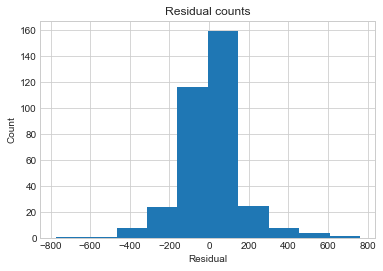

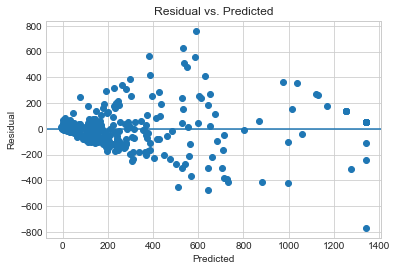

In [164]:
# Calculate the error, also called the residual.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The assumption of multivariate normality seems fine here, but homoscedasticity is violated. There is much more variance in the residuals as the estimates get larger. 

We know that there's a close relationship between property crime and population, so let's focus on population as a potential source for improved features. The population squared feature should have helped a bit to improve predictions in the larger values, but let's add the 'city' feature as well to account for the major difference between urban areas and smaller communities. The linear relationship between property crime and population gets messier around 200,000, according to the original scatterplot, so we'll use that as the threshold for 'city'. 

In [165]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_sub['property_crime'].values.reshape(-1, 1)
X2 = crime_sub[['population','pop2','city','robbery','murder']]
regr.fit(X2, Y)

# Inspect the results.
print(lm.summary())

# Extract predicted values.
predicted = regr.predict(X2).ravel()
actual = crime_sub['property_crime']

rms = sqrt(mean_squared_error(actual, predicted))
print(rms)

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     400.6
Date:                Wed, 25 Oct 2017   Prob (F-statistic):          7.77e-128
Time:                        14:13:30   Log-Likelihood:                -2255.3
No. Observations:                 348   AIC:                             4521.
Df Residuals:                     343   BIC:                             4540.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.7354     15.846     -0.741      0.4

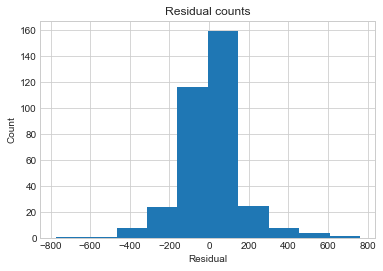

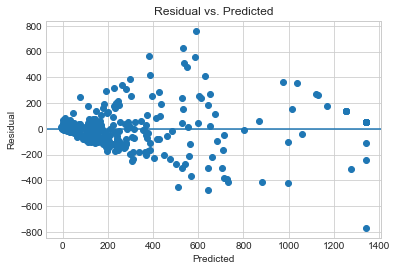

In [166]:
# Calculate the error, also called the residual.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The results here look the same as they did without the 'city' variable. I assume this is an error in the code, but it could also be the fact that the 'city' coefficient is miniscule. 

In the next component of this activity, I will evaluate and revise the model. 

## New Data for Cross-Validation ##

Since all of the 2013 data was used to build the initial model, we need some holdout data to test it. For that purpose, we will use the 2014 crime data from New York. To get started, we'll inspect and preprocess the data using the same steps that we did for 2013.

In [167]:
crime14 = pd.read_excel('/Users/teresaoneill/Dropbox/Thinkful/Datasets/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls', skiprows=4, skip_footer=7)
print(len(crime14))
crime14.head()

369


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1851,0,0,nan,0.000,0,0,11.000,1,10.000,0,0.000
1,Addison Town and Village,2568,2,0,nan,0.000,1,1,49.000,1,47.000,1,0.000
2,Afton Village4,820,0,0,0.000,nan,0,0,1.000,0,1.000,0,0.000
3,Akron Village,2842,1,0,nan,0.000,0,1,17.000,0,17.000,0,0.000
4,Albany4,98595,802,8,54.000,nan,237,503,3888.000,683,3083.000,122,12.000


count       369.000
mean      37814.824
std      441159.058
min          79.000
25%        2631.000
50%        6581.000
75%       15408.000
max     8473938.000
Name: population, dtype: float64
count   369.000
mean      1.453
std      17.694
min       0.000
25%       0.000
50%       0.000
75%       0.000
max     333.000
Name: murder, dtype: float64
count     369.000
mean       60.661
std       866.481
min         0.000
25%         0.000
50%         1.000
75%         4.000
max     16581.000
Name: robbery, dtype: float64
count      368.000
mean       698.361
std       7123.614
min          0.000
25%         25.000
50%         76.000
75%        271.500
max     135747.000
Name: property_crime, dtype: float64


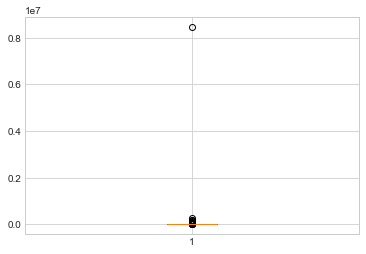

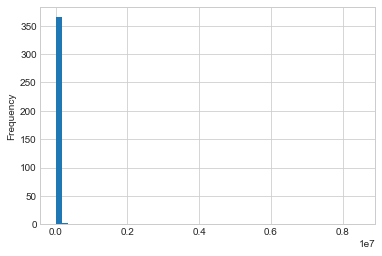

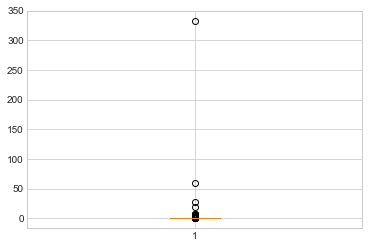

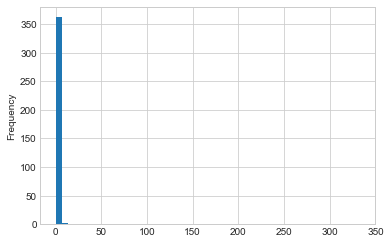

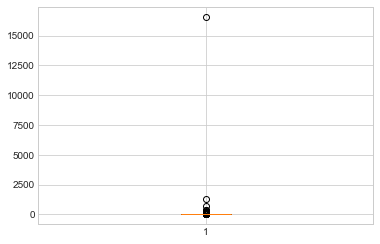

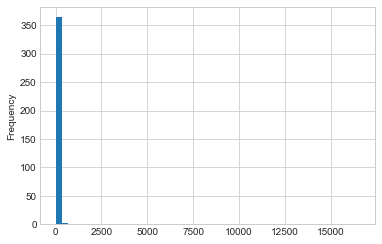

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2066: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2081: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:2082: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


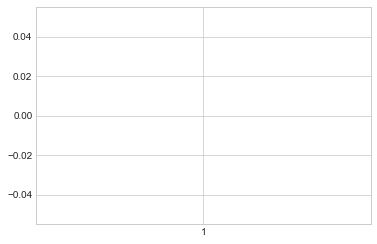

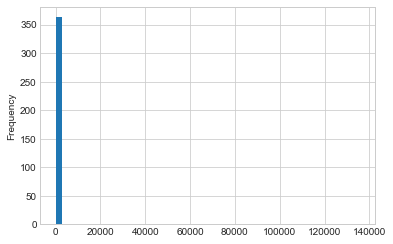

In [168]:
#Rename the columns.

crime14.columns=['city', 'population','violent_crime', 'murder', 'rape1', 'rape2', 'robbery','agg_assault','property_crime','burlary','larceny','vehicle','arson']

#Take the subset of relevant numeric columns.

crime14_sub = crime14[['population','murder','robbery','property_crime']]

#Generate descriptions for each column.

for col in crime14_sub.columns:
    print(crime14_sub[col].describe())

#Look at the distributions of each with a boxplot and a histogram.

plt.boxplot(crime14_sub['population'])
plt.show()

crime14_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime14_sub['murder'])
plt.show()
crime14_sub['murder'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime14_sub['robbery'])
plt.show()
crime14_sub['robbery'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime14_sub['property_crime'])
plt.show()
crime14_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

count     369.000
mean    12560.366
std     14750.893
min        79.000
25%      2631.000
50%      6581.000
75%     15408.000
max     55722.000
Name: population, dtype: float64
count   369.000
mean      0.192
std       0.514
min       0.000
25%       0.000
50%       0.000
75%       0.000
max       2.000
Name: murder, dtype: float64
count   369.000
mean      5.902
std      12.286
min       0.000
25%       0.000
50%       1.000
75%       4.000
max      48.000
Name: robbery, dtype: float64
count    369.000
mean     243.667
std      371.814
min        0.000
25%       25.000
50%       77.000
75%      276.000
max     1414.000
Name: property_crime, dtype: float64


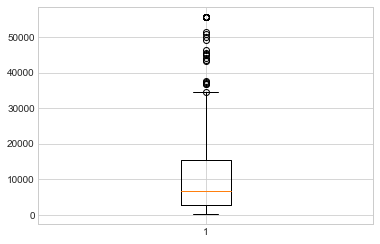

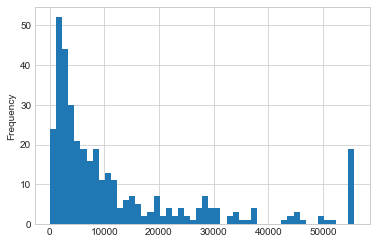

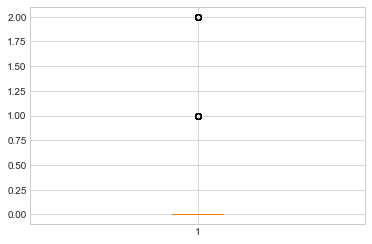

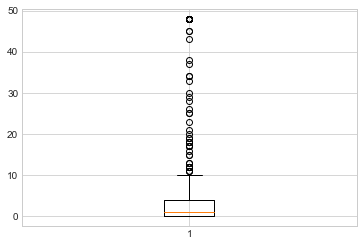

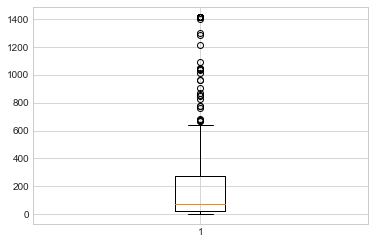

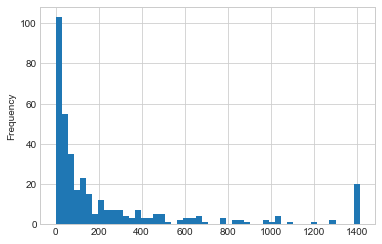

In [169]:
#Winsorize to adjust high outliers.
for col in crime14_sub.columns:
    stats.mstats.winsorize(crime14_sub[col], limits=(0, 0.05), inplace=True),
    print(crime14_sub[col].describe())

plt.boxplot(crime14_sub['population'])
plt.show()
crime14_sub['population'].plot(kind='hist', bins=50)
plt.show()

plt.boxplot(crime14_sub['murder'])
plt.show()

plt.boxplot(crime14_sub['robbery'])
plt.show()

plt.boxplot(crime14_sub['property_crime'])
plt.show()

crime14_sub['property_crime'].plot(kind='hist', bins=50)
plt.show()

In [170]:
#Code the exponential and binary variables.
crime14_sub['pop2'] = crime14_sub['population'].apply(lambda x: x**2)
crime14_sub['city'] = np.where(crime14_sub['population']>=200000, 1, 0)
crime14_sub['robbery'] = np.where(crime14_sub['robbery']>0, 1, 0)
crime14_sub['murder'] = np.where(crime14_sub['murder']>0, 1, 0)

print(crime14_sub['pop2'].describe())
print(crime14_sub['robbery'].value_counts())
print(crime14_sub['murder'].value_counts())

count          369.000
mean     374761956.420
std      779145053.109
min           6241.000
25%        6922161.000
50%       43309561.000
75%      237406464.000
max     3104941284.000
Name: pop2, dtype: float64
1    196
0    173
Name: robbery, dtype: int64
0    318
1     51
Name: murder, dtype: int64


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

We are now ready to test the original regression model on the new data. Let's run it and see how it fares. 

In [171]:
# Instantiate model
lm2 = linear_model.LinearRegression()

# Fit Model with paremeters from our 2013 "training data"
#Already done above, but repeated here so I don't get lost!
lm2.fit(X2, Y)

#Instantiate the dependent variable from the 2014 "test data".
y_2014 = crime14_sub['property_crime']

# Predict
y_pred = lm2.predict(y_2014)

# Evaluate the error with RMSE
print(np.sqrt(metrics.mean_squared_error(Y, y_2014)))
print(lm2.summary())

ValueError: Expected 2D array, got 1D array instead:
array=[  1.10000000e+01   4.90000000e+01   1.00000000e+00   1.70000000e+01
   1.41400000e+03   2.04000000e+02   7.00000000e+00   3.00000000e+01
   2.00000000e+00   1.41400000e+03   0.00000000e+00   1.98000000e+02
   4.90000000e+02   6.00000000e+00   2.50000000e+01   2.50000000e+01
   6.00000000e+00   1.20000000e+01   1.40000000e+01   6.50000000e+01
   7.30000000e+01   5.99000000e+02   1.48000000e+02   2.45000000e+02
   1.23000000e+02   4.54000000e+02   1.41400000e+03   3.00000000e+00
   8.60000000e+01   9.00000000e+00   1.00000000e+01   2.10000000e+01
   9.00000000e+00   1.70000000e+01   8.54000000e+02   1.28000000e+02
   2.50000000e+01   5.00000000e+00   1.41400000e+03   5.50000000e+01
   3.20000000e+01   3.50000000e+01   4.70000000e+02   1.20000000e+01
   3.01000000e+02   7.50000000e+01   9.00000000e+00   3.30000000e+01
   2.06000000e+02   4.00000000e+00   6.20000000e+01   2.00000000e+00
   3.80000000e+01   4.10000000e+01   4.00000000e+01   2.00000000e+00
   9.00000000e+00   1.41400000e+03   2.20000000e+01   1.08000000e+02
   4.20000000e+01   4.77000000e+02   1.41400000e+03   2.00000000e+00
   3.80000000e+01   1.51000000e+02   6.30000000e+01   2.25000000e+02
   1.41400000e+03   1.20000000e+01   3.42000000e+02   2.30000000e+01
   4.70000000e+01   8.00000000e+00   7.90000000e+01   4.30000000e+01
   1.26000000e+02   4.20000000e+01   2.51000000e+02   6.85000000e+02
   9.00000000e+00   9.60000000e+01   3.20000000e+01   8.00000000e+01
   2.41000000e+02   4.00000000e+00   1.28000000e+02   1.40000000e+02
   3.71000000e+02   2.80000000e+02   6.10000000e+01   7.50000000e+01
   2.06000000e+02   2.80000000e+01   1.15000000e+02   2.70000000e+02
   9.64000000e+02   7.70000000e+01   4.00000000e+00   3.60000000e+01
   6.11000000e+02   4.80000000e+01   1.05000000e+02   2.66000000e+02
   3.00000000e+01   4.70000000e+01   2.40000000e+01   8.00000000e+00
   6.10000000e+01   3.80000000e+01   3.60000000e+01   2.10000000e+01
   2.36000000e+02   8.48000000e+02   1.70000000e+01   4.55000000e+02
   2.79000000e+02   1.03700000e+03   2.44000000e+02   1.12000000e+02
   3.50000000e+02   3.00000000e+00   9.70000000e+01   2.00000000e+00
   3.38000000e+02   4.70000000e+02   6.77000000e+02   5.10000000e+01
   7.80000000e+01   2.10000000e+01   1.41400000e+03   6.02000000e+02
   1.60000000e+01   4.60000000e+01   1.69000000e+02   2.00000000e+01
   3.60000000e+01   4.90000000e+01   6.69000000e+02   1.04200000e+03
   1.29000000e+02   2.60000000e+01   1.00000000e+01   2.90000000e+01
   1.29000000e+02   5.50000000e+01   2.68000000e+02   9.65000000e+02
   3.90000000e+02   1.90000000e+01   3.50000000e+01   5.70000000e+01
   3.50000000e+01   1.16000000e+02   1.67000000e+02   1.10000000e+02
   1.30000000e+01   1.37000000e+02   1.30000000e+02   9.00000000e+00
   1.50000000e+01   3.00000000e+00   1.41400000e+03   1.80000000e+01
   1.28500000e+03   1.09000000e+03   2.86000000e+02   6.00000000e+00
   3.15000000e+02   0.00000000e+00   8.00000000e+01   1.00000000e+01
   6.72000000e+02   6.70000000e+01   4.12000000e+02   2.90000000e+01
   2.80000000e+01   4.14000000e+02   4.31000000e+02   9.90000000e+01
   8.20000000e+01   5.00000000e+00   1.26000000e+02   2.15000000e+02
   1.22000000e+02   4.40000000e+01   1.40000000e+01   1.15000000e+02
   2.64000000e+02   4.70000000e+01   1.65000000e+02   1.57000000e+02
   4.10000000e+01   1.86000000e+02   7.00000000e+00   1.17000000e+02
   1.72000000e+02   1.00000000e+00   3.76000000e+02   1.10000000e+01
   9.30000000e+01   3.32000000e+02   1.20000000e+01   6.10000000e+01
   1.51000000e+02   1.18000000e+02   3.20000000e+01   8.28000000e+02
   1.68000000e+02   5.60000000e+01   2.20000000e+01   2.90000000e+02
   2.80000000e+01   6.00000000e+00   1.90000000e+01   1.17000000e+02
   8.00000000e+01   2.05000000e+02   1.03100000e+03   1.70000000e+01
   2.83000000e+02   8.66000000e+02   1.40100000e+03   7.76000000e+02
   2.03000000e+02   1.21300000e+03   5.29000000e+02   1.41400000e+03
   3.80000000e+01   1.41400000e+03   3.97000000e+02   3.79000000e+02
   4.00000000e+00   6.30000000e+01   1.86000000e+02   5.80000000e+01
   9.50000000e+01   4.81000000e+02   0.00000000e+00   2.76000000e+02
   8.00000000e+00   2.40000000e+01   4.34000000e+02   2.44000000e+02
   5.00000000e+01   4.40000000e+01   2.20000000e+01   4.51000000e+02
   2.48000000e+02   3.07000000e+02   3.92000000e+02   9.00000000e+00
   2.11000000e+02   6.28000000e+02   1.45000000e+02   2.60000000e+01
   1.50000000e+01   2.50000000e+01   1.89000000e+02   1.27000000e+02
   7.40000000e+01   5.50000000e+01   6.00000000e+01   1.40000000e+01
   2.50000000e+01   7.80000000e+01   7.00000000e+00   3.00000000e+00
   5.02000000e+02   2.90000000e+01   2.93000000e+02   4.00000000e+00
   1.15000000e+02   1.57000000e+02   6.68000000e+02   1.41400000e+03
   3.90000000e+01   2.60000000e+01   2.90000000e+01   6.43000000e+02
   6.30000000e+01   1.47000000e+02   2.70000000e+01   1.41400000e+03
   1.94000000e+02   6.25000000e+02   4.10000000e+01   9.01000000e+02
   2.10000000e+01   5.40000000e+01   9.20000000e+01   1.00000000e+00
   5.70000000e+01   1.06000000e+02   9.00000000e+00   1.17000000e+02
   5.90000000e+02   2.17000000e+02   1.29000000e+02   1.41400000e+03
   7.00000000e+01   0.00000000e+00   1.50000000e+02   3.14000000e+02
   6.70000000e+01   6.70000000e+01   3.60000000e+01   2.10000000e+01
   0.00000000e+00   1.32000000e+02   6.00000000e+00   5.30000000e+01
   8.00000000e+00   2.40000000e+01   1.43000000e+02   7.78000000e+02
   8.40000000e+01   9.70000000e+01   1.10000000e+01   3.08000000e+02
   3.91000000e+02   2.90000000e+01   5.40000000e+01   1.00000000e+00
   1.03000000e+02   6.10000000e+01   1.41400000e+03   8.60000000e+01
   5.60000000e+01   3.51000000e+02   1.01500000e+03   1.41400000e+03
   5.50000000e+01   4.50000000e+01   1.14000000e+02   0.00000000e+00
   2.00000000e+00   3.90000000e+02   1.41400000e+03   1.50000000e+01
   5.80000000e+02   8.90000000e+01   5.06000000e+02   7.50000000e+01
   7.50000000e+01   5.90000000e+01   5.80000000e+01   1.54000000e+02
   1.29600000e+03   1.99000000e+02   1.03000000e+02   2.00000000e+01
   4.96000000e+02   2.10000000e+01   1.56000000e+02   9.00000000e+00
   3.30000000e+01   7.64000000e+02   4.40000000e+01   1.04600000e+03
   4.10000000e+01   7.10000000e+01   1.80000000e+01   4.00000000e+00
   1.41400000e+03   4.30000000e+01   1.41400000e+03   2.09000000e+02
   1.00000000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Unlike examples that I've looked at, I'm getting an error here. I tried adding .reshape(-1,1) when setting up the dependent variable, but it did not help. Until I understand what is causing the error at the prediction step, I will not be able to continue with cross-validation of OLS models.

Once I do, I'll continue the cross-validation process with folds.